<a href="https://colab.research.google.com/github/steed360/3D-Graphics/blob/master/Estimate_Uncertain_In_Future_Campaign_Responses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ESTIMATING UNCERTAINTY OF FUTURE CAMPAIGN RESPONSES**



**Purpose of this Notebook**

Investigation into predicting campaign effectiveness.  

Scenario: A previous campaign contacted 1000 people and had a response rate of 5%. Repeating the campaign (e.g. on a different subset of the same segment), how many responses can be expected?

Assuming an underlying Bernouilli variable (underlying response propensity) of 0.05 (5%), show different ways to apply this in predicting the expected number of responses to a new campaign. 

Here 4 different ways are calculated:



IGNORING UNCERTAINTY


a)  Apply a **fixed point** (multiply the unseen sample by 0.05). So to find the expected response rate, simply  multiply the number of people to be contacted by 0.05. 

ACCOUNT FOR KNOWN UNKNOWNS

b)  Acknowledge **sampling error**. Sample a lot of response probabilities from the sampling distribution (given by the Binomial Distribution). Apply each of these in turn as in a). This will give a simulated distribution (posterior distribution).  Find the 5th and 85th percentiles from each. 

Note that this gives and identical result to calculating the 95% confidence interval in the classical (Frequentist) way.

c) Acknowledge that the above method does not cover all of the uncertainty in the data.  Repeat the above but this time instead of multiplying each probability by the new campaign size, actually use the probability to predict an outcome (using the Binomial distribution a second time). In Bayesian Statistics Terms this gives the Predictive Posterior Distribution.

Sample from this many times and, again, find the response values that lie on the 5% and 95%  the credible interval.

GUESS UNKNOWN UNKNOWNS

d) Here just add a factor of 10 to the above confidence intervals.




In [235]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
#import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
#from scipy.interpolate import griddata

**Notebook structure**
<bR><bR>
TOP:  Calculate the distributions for b) and c) above. 
Two dataframes: one showing the simulations for next campaign.
The other carries 95% interval values. 
Both are used in the charts.
<bR><bR>
BOTTOM: Make a visualization in matplotlib/plotnine.

**CALULATIONS**

In [237]:
Original_Campaign_Size       = 1000 # sample size
New_Campaign_Size            = 1000
Original_Response_Rate       = 0.1  # NB: Assumption is IID Bernouilli variable
Original_Campaign_Responses  = Original_Campaign_Size * Original_Response_Rate



TASK A) Esimate the new number of responses

In [240]:
# Part a) 
New_Campaign_Responses = New_Campaign_Size * Original_Response_Rate  

TASK B) Account for sampling error (using the binomial sampling distribution) 

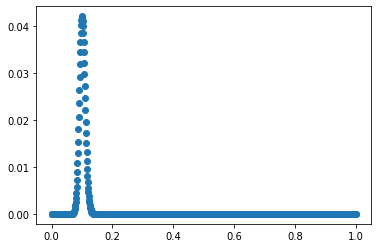

In [241]:
# Set up a list of underlying possible response_rates 
# The distribution plotted sums up to 1 and the height of the curve (0.1) 
# represents the most plausible value in the population.

grid_points = 1000
p_grid = np.linspace ( 0, 1, grid_points )
prior  = np.repeat ( 5, grid_points )  # this is a completley uniformative prior that will get washed away
ustd_posterior = stats.binom.pmf ( k=Original_Campaign_Responses, n=Original_Campaign_Size, p= p_grid ) * prior
posterior = ustd_posterior / ustd_posterior.sum()
plt.plot (p_grid, posterior, 'o')

b2) Calculate the confidence intervals the Bayesisan way

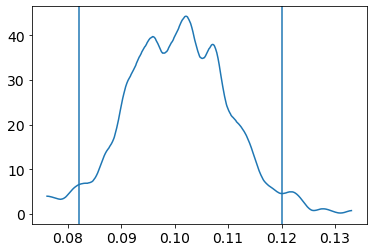

In [271]:
# Calculate the 90% confidence interval. 
# Firstly do it the Bayesian Analysis way.

# Get 1000 samples from the above distribution

#samples_b = np.random.choice(p_grid, p=posterior, size=int(1e5), replace=True)
samples_b = np.random.choice(p_grid, p=posterior, size=New_Campaign_Size, replace=True)

# If you have samples the confidence intervals are just percentiles.
lstCI_b = np.percentile (samples_b, [2.5,97.5])

az.plot_kde ( samples_b)
plt.axvline (lstCI_b[0] )
plt.axvline (lstCI_b[1] )

# The figures below are the upper and lower bounds that the population response_rate could be (if IID)
# The interval is also shown on the chart.
# The chart is a simulation from the sampling distribution. You could use this in a violin plot as well of course.

In [272]:
# Here is the 95% confidence interval (which is the same using the school book method)

# If you have samples the confidence intervals are just percentiles.
lstCI_b = np.percentile (samples_b, [2.5,97.5])
lstCI_b

array([0.08208208, 0.12012012])

b_iii Apply the values at the lower and upper confidence interval bounds to the future campaign

In [249]:
# This is the expected (95%) confidence range.
print ( New_Campaign_Size * lstCI_b [0] ) 
print ( New_Campaign_Size * lstCI_b [1] ) 

83.08308308308308
120.12012012012012


b_iv For graphing, turn the list of 1000 probabilities into a simulation of expected responses

In [274]:
samples_b_final =  samples_b * New_Campaign_Size


b_v Now we can double check the confidence intervals.

In [329]:
# If you have samples the confidence intervals are just percentiles.

lst_simulation_b_intervals =np.percentile (samples_b_final, [2.5,97.5])
lst_simulation_b_intervals

array([ 82.08208208, 120.12012012])

TASK C) Sample probabilities from the posterior and then simulate from that to create a predictive posterior and then simulate from  that.

This will give a slightly broader spread of possible future campaign responeses than B because it builds in more of the known uncertainty.

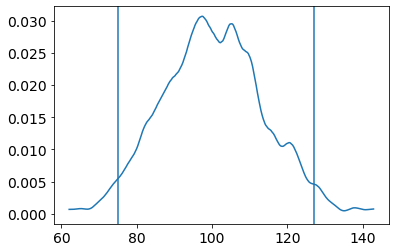

In [270]:
# We have already calculated the posterior and have the grid points:
#grid_points
#posterior

#probs = np.random.choice(p_grid, p=posterior, size=int(1e5), replace=True)

# previous code
#samples = np.random.choice(p_grid, p=posterior, size=int(1e5), replace=True)

# New code
number_of_simulations= New_Campaign_Size
campaign_size = 1000

probs = np.random.choice(p_grid, p=posterior, size=New_Campaign_Size, replace=True)
samples_c = stats.binom.rvs(n=campaign_size, p= probs, size=New_Campaign_Size )

# samples_c = stats.binom.rvs(n=campaign_size, p= probs, size=10000 )

az.plot_kde ( samples_c)

# If you have samples the confidence intervals are just percentiles.
lstCI_c = np.percentile (samples_c, [2.5,97.5])
# print (  lstCI_c)
plt.axvline (lstCI_c[0] )
plt.axvline (lstCI_c[1] )

# This is a broader distribution than before.
#print ( [ lstCI[0] / trials, lstCI[1]/ trials ])

C1) Extract the upper and lower bounds (the lines)

In [330]:
lst_simulation_c_intervals = np.percentile (samples, [2.5,97.5])
print (  lst_simulation_c_intervals)

[ 76. 129.]


**TASK D CALCULATE UNKONWN UNKNOWN - GUESS THE EFFECT OF PEOPLE CHANGING SEGMENT**

In [340]:
d_lower_bound_guess = lst_simulation_c_intervals[0] * 0.9
d_upper_bound_guess = lst_simulation_c_intervals[1] * 1.1

**NOW PACK UP THE DATA AND STATISTICS GENERATED INTO DATA FRAMES**

First the simulations from B) and C) - 1000 future campaigns were simulated

In [267]:
len ( samples_b )

100000

In [265]:
New_Campaign_Size

1000

In [371]:
np.random.seed(123)
n = 20
mu = (10, 10)
sigma = (1, 3.6)

# create dummy data for 

df = pd.DataFrame({
    
    'value'    :  np.hstack([  np.repeat (1000,1), samples_b_final, samples_c , np.repeat (1000,1) ] ) ,
    'scenario':   np.hstack ( [  np.repeat ( 'a) Point\nestimate', 1),                                 \
                                 np.repeat ( 'b) Apply\nSampling\nDistribution', New_Campaign_Size )  , \
                                 np.repeat ( 'c) Use all known\nuncertainty',   New_Campaign_Size),   \
                                 np.repeat ( 'd)Add extra\nuncertainty',   1)
                                 ]),      



} )

df['scenario'] = df['scenario'].astype(pdtypes.CategoricalDtype(categories=['a) Point\nestimate', 'b) Apply\nSampling\nDistribution', 'c) Use all known\nuncertainty', 'd)Add extra\nuncertainty']))



# DataFrame for the summary information about the distributions.



df_sum = pd.DataFrame ( 
   {
       'scenario' : ['a) Point\nestimate', 'b) Apply\nSampling\nDistribution', 'b) Apply\nSampling\nDistribution', 'c) Use all known\nuncertainty', 'c) Use all known\nuncertainty', 'd)Add extra\nuncertainty', 'd)Add extra\nuncertainty'],
       'vals' : [ New_Campaign_Responses,  lst_simulation_b_intervals[0],  lst_simulation_b_intervals[1]  ,lst_simulation_c_intervals[0],  lst_simulation_c_intervals[1], d_lower_bound_guess, d_upper_bound_guess],
   }
) 


df_sum['vals'] = df_sum['vals'].astype (int)

In [133]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import transforms
import matplotlib


import pandas as pd
import pandas.api.types as pdtypes # for (sorted) categories.

import seaborn as sns
#from matplotlib.ticker import FixedLocator, FixedFormatter

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/
import pandas as pd
import plotnine

%matplotlib inline
from  mizani import formatters # for better axis labelling
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.patches import Rectangle


In [14]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
BLUE5, BLUE6 = '#92CDDD', '#2E869D'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1, ORANGE2, ORANGE3 = '#F79747', '#FAC090', '#F36721'

In [15]:
np.repeat ( 3,1 )

array([3])

**DATA VISUALIZATION**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import transforms
import matplotlib


import pandas as pd
import pandas.api.types as pdtypes # for (sorted) categories.

import seaborn as sns
#from matplotlib.ticker import FixedLocator, FixedFormatter

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/
import pandas as pd
import plotnine

%matplotlib inline
from  mizani import formatters # for better axis labelling
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.patches import Rectangle


,when,vals
0,before,7
1,before,9
2,after,6
3,after,11
4,other,5


In [127]:
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

In [23]:
def SWD_theme ():

   
    font = "Arial"
    t=theme_minimal(base_size = 10, base_family = font ) 

    t2 = theme(
      panel_grid_major = element_blank(),
      panel_grid_minor = element_blank(),

      axis_line = element_line(size = .1, color = GRAY9),
      axis_text = element_text(color = GRAY3, size = 12),

      #axis.ticks.x = element_line(size = 0.5, color = GRAY9),
      #axis.ticks.y = element_line(size = 0.5, color = GRAY9),
        
      axis_title = element_text(color = GRAY3),

      #axis_title_y = element_text(hjust = 1, margin = margin(0, 6, 0, 15, "pt")),
      #axis_title_x = element_text(hjust = 0, margin = margin(6, 0, 15, 0, "pt")),
      #plot_subtitle = element_text(color = GRAY4, size= 8),

      plot_title = element_text(color = GRAY4, size= 12 ),
        
      # I don't think this line is implemented in plotnine
      #plot_title_position = "plot", # This aligns the plot title to the very left edge
        
      #plot_caption = element_text(hjust = 0, color = GRAY6),
      #plot_caption_position = "plot",

      #plot_margin = margin(.5,.5,.5,.5,"cm"),
      #plot_margin = (0.4 ),  
        
      strip_text = element_text(color = GRAY7)) 
    
    return t+ t2

In [124]:
# empathy87 on github

def rainbow_text(x, y, text, colors, spacing=20, ax=None, **kw):
    colors = list(reversed(colors))
    t = ax.transData
    canvas = ax.figure.canvas

    for i, line in enumerate(reversed(text.split('\n'))):
        strings = line.split('||')
        for s, c in zip(strings, colors[i]):
            text = ax.text(x, y, s, color=c, transform=t, **kw)
            text.draw(canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, x=ex.width, 
                                       units='dots')

        t = transforms.offset_copy(ax.transData, x=0, y=(i + 1) * spacing, 
                                   units='dots')
        

In [286]:
df_sum

,scenario,vals
0,a) Point\nestimate,7
1,b) Apply\nSampling\Distribution,9
2,c) Use all known\nuncertainty,6
3,c) Use all known\nuncertainty,11
4,d)Add extra\nuncertainty,5


/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_ydensity : Removed 2 rows containing non-finite values.
/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.
/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


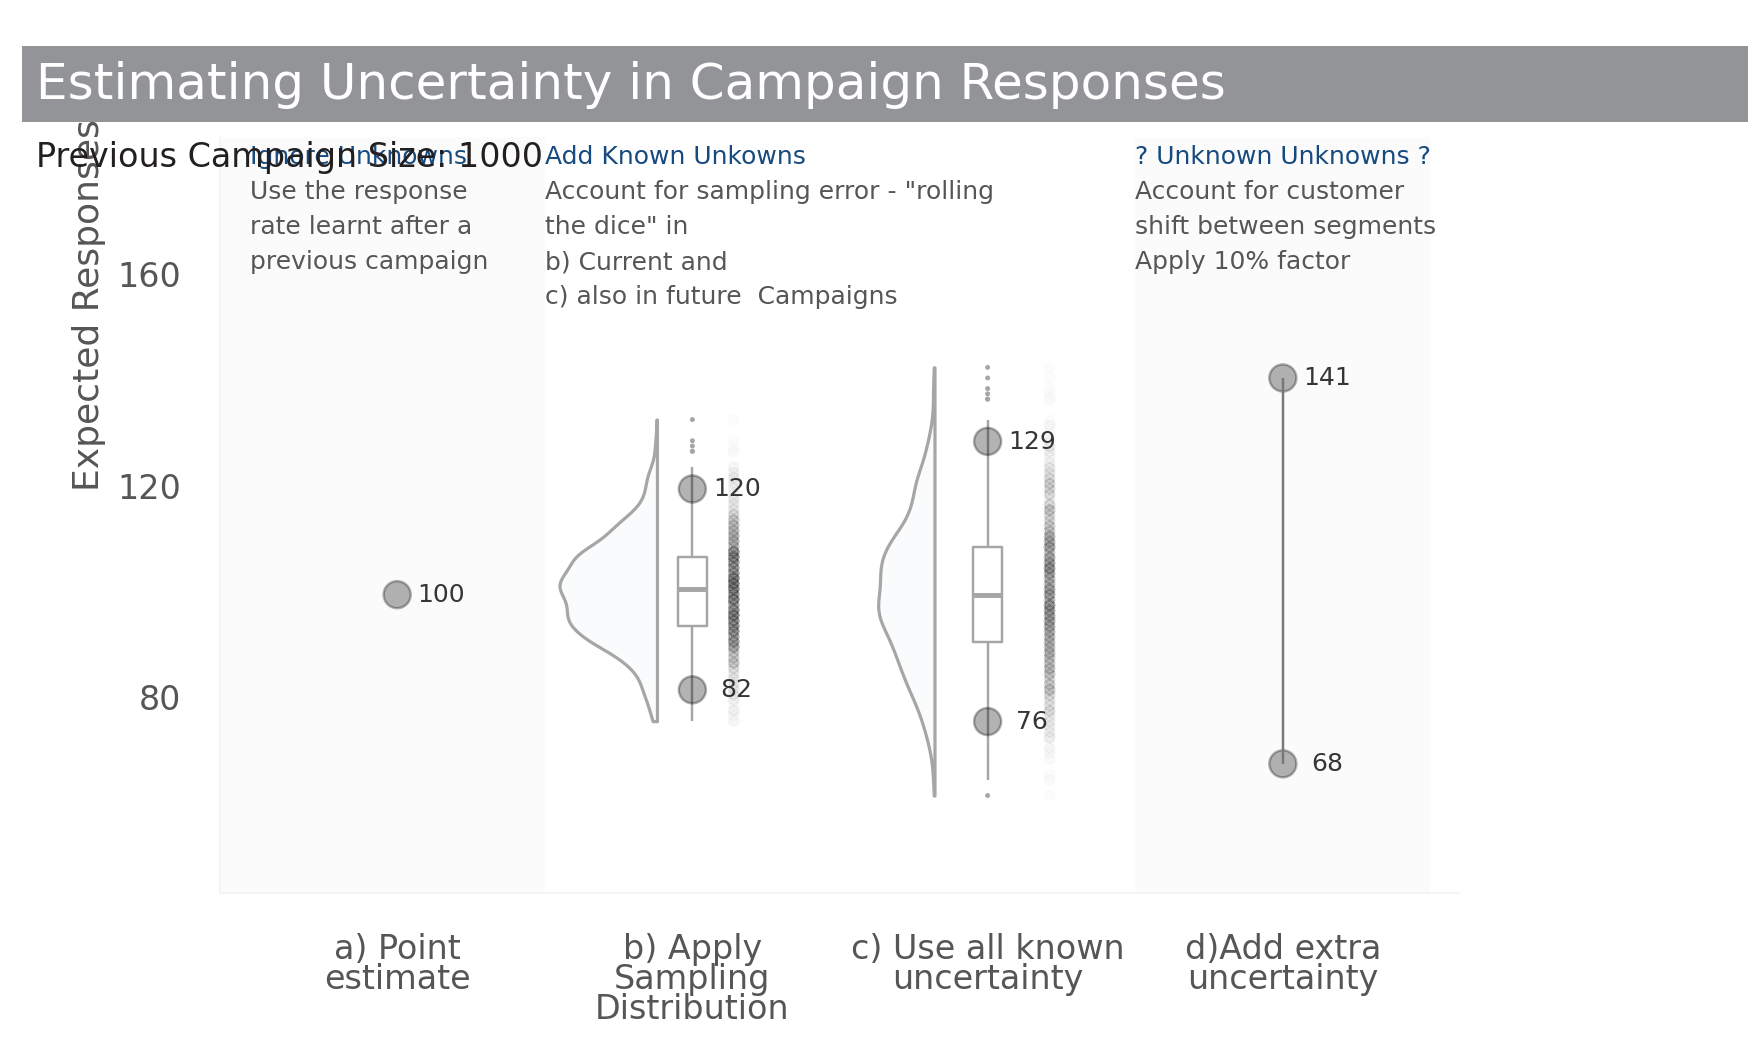

In [377]:
t = theme(         
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.52),
          axis_title_x = element_text(size = 9, color = GRAY3),
          panel_grid_major_y=element_blank()
)

lsize = 0.65
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x 
    return 

m1 = aes(x=stage('scenario', after_scale='x+shift*x'))                 # shift outward
m2 = aes(x=stage('scenario', after_scale='x+shift_point*x'))           # shift outward
m3 = aes( stage('scenario', after_scale='x+shift_point*x' ),y='vals' ) # shift outward

fig = \
(ggplot(df, aes('scenario', 'value'))
  + geom_violin(m1, alpha=0.04, color=GRAY8, fill=BLUE3, style="left", size=lsize) 
  + geom_boxplot( width=0.1, alpha=0.09, color=GRAY8,  outlier_size=0  )
  + geom_point(m2, alpha=0.01)
  + geom_point ( aes(y='vals' ),data=df_sum , size=5, alpha=0.3)
  + geom_text( data=df_sum, mapping=aes(label = ( 'vals') ,y  = 'vals' ) , color = GRAY1, size = 9  , alpha=0.9, nudge_x=0.15)  
  + SWD_theme() + t
  + labs(y = "Expected Responses"  , x = "")
  + scale_y_continuous(limits = [50, 180])
  + geom_line (aes(x = 'scenario', y = 'vals') , data=df_sum[df_sum.scenario=='d)Add extra\nuncertainty'] , color=GRAY5   )

  
).draw(show=False, return_ggplot=False) 

# Having got the plot make some other annotations.
ax1 = fig.axes[0]

# Rectangle for forecast
#ax1.add_patch(Rectangle((2015, 5), 10, -20, facecolor=GRAY7))

# Connect the two dots in column d
ax1.axvline ( x='d)Add extra\nuncertainty', ymin=68, ymax=141, color =GRAY2 )


ax0 = fig.add_axes( (0,0,1,1))
ax0.axis('Off') # don't draw anything.

ax1.add_patch(Rectangle( (-1, 0  ),  2.5, 200, facecolor=GRAY9,alpha=0.05)  )
#ax1.add_patch(Rectangle( (1.5, 0 ),  2, 200, facecolor=GREEN2,alpha=0.05) )
ax1.add_patch(Rectangle( (3.5,0 ),  1, 200, facecolor=GRAY9,alpha=0.05) )

# Columns Annotations

#annotation_text = "2 employees quit in May. We nearly kept up with incoming calls \n" 
#ax1.annotate(annotation_text,xy=(1,5),xytext=(1,10),color=BLUE2,fontsize=12)


label_y = 155

#$\\mathit{OK}$
rainbow_text(0.5, label_y,
             'Ignore Unknowns\n'
             'Use the response\n'
             'rate learnt after a\n'
             'previous campaign\n ',
             [[BLUE1], [GRAY3], [GRAY3], [GRAY3], [GRAY3] ],
             spacing=35,
             ax=ax1,
             fontsize=9)

rainbow_text(1.5, label_y,
             'Add Known Unkowns\n'
             'Account for sampling error - "rolling \n'
             'the dice" in \nb) Current and\n'
             'c) also in future  Campaigns',
             [[BLUE1], [GRAY3], [GRAY3], [GRAY3], [GRAY3] ],
             spacing=35,
             ax=ax1,
             fontsize=9)

rainbow_text(3.5, label_y,
             '? Unknown Unknowns ?\n'
             'Account for customer\n'
             'shift between segments\n'
             'Apply 10% factor\n ',
             [[BLUE1], [GRAY3], [GRAY3], [GRAY3], [GRAY3] ],
             spacing=35,
             ax=ax1,
             fontsize=9)

# titile the plot
ax0.text(0.01, 0.92,
         'Estimating Uncertainty in Campaign Responses' + ' ' * 32,
         fontsize=18,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7,  # background color
               'pad': 5,  # add more padding
               'edgecolor': 'none'})  # no border

# add survey question
ax0.text(0.01, 0.85, 'Previous Campaign Size: 1000', fontsize=12, color=GRAY6)





fig.dpi = 200
width_in = 8
fig.set_size_inches(width_in , width_in / 1.63) 
